# Random Dice and the CLT

#### Setup

In [1]:
%matplotlib inline

from collections import Counter
from itertools import filterfalse
from numbers import Number

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display_html
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import label
from scipy.optimize import fmin
from scipy.stats import chisquare, norm
from tqdm.notebook import tqdm, trange

# Homogenise matplotlib plotting.
mpl.rc("axes", grid=True)
mpl.rc("grid", linestyle="--", alpha=0.4)
mpl.rc("legend", loc="best")

### Re-define functions from the first exercise

In [2]:
def random_die(size=None, n=6, rng=None):
    """Return the result(s) of random die throws.
    
    Parameters
    ----------
    size : None, int, or array-like
        The number of samples to return. If None, a single sample will be returned.
    n : int
        The number of sides of the die.
    rng : numpy random Generator or None
        Generator which can be used to make runs repeatable if given.
        
    Returns
    -------
    samples : int or array-like
        If `size` is `None`, a single random sample is returned. Otherwise,
        an array of integers is returned.
    
    """
    if rng is None:
        # Initialise the random number generator.
        rng = np.random.default_rng()

    return rng.integers(1, high=n, size=size, endpoint=True)


def random_dice(dice=None, size=None, n=6, rng=None):
    """Return the result(s) of random dice throw sums.
    
    Parameters
    ----------
    dice : int or None
        The number of dice to sum. If `dice` is None and `n` is a single int, 1 die will be 
        assumed. If multiple values are given for `n`, the number of 
        values in `n` will determine the number of dice.
    size : None, int, or array-like
        The number of samples to return. If None, a single sample will be returned.
    n : int or array-like
        The number of sides of each of the dice. If multiple values are given, each value in
        `n` will result in a die-throw using a die with the given number of sides.
    rng : numpy random Generator or None
        Generator which can be used to make runs repeatable if given.
        
    Returns
    -------
    samples : int or array-like
        If `size` is `None`, a single random sample is returned. Otherwise,
        an array of integers is returned.
    
    """
    if rng is None:
        # Initialise the random number generator.
        rng = np.random.default_rng()

    if isinstance(n, Number):
        if dice is None:
            dice = 1
        # Check if `n` is just a single number.
        n = np.ones(dice, dtype=int) * n
    else:
        n = np.asarray(n)

    return sum(random_die(size=size, n=n_i, rng=rng) for n_i in n)


def sum_disc_distr(*distrs):
    """Calculate the distribution of the sum of discrete uniform distributions.
    
    A recursive approach is used whereby repeated function calls are used if more 
    than two dstributions are given.
    
    Parameters
    ----------
    *distrs : pandas Series
        Series containing probabilities with the corresponding values as the index.    
    
    Returns
    -------
    sum_distr : pandas Series
        Series containing the resulting probabilities, with the corresponding values
        as the index.
        
    Raises
    ------
    ValueError : If no arguments are given.
    
    """
    if len(distrs) < 1:
        raise ValueError("At least 1 distribution must be given.")
    if len(distrs) == 1:
        # Nothing to do, simply return the distribution.
        return distrs[0]
    if len(distrs) > 2:
        # Compute the sum of the first two distributions and try again.
        return sum_disc_distr(sum_disc_distr(*distrs[:2]), *distrs[2:])

    # Here, there must be 2 distributions.
    # The distribution of their sum will be determined here.
    d1, d2 = distrs

    a = min(d1.index)
    b = max(d1.index)
    c = min(d2.index)
    d = max(d2.index)

    probabilities = {}
    for z in range(a + c, b + d + 1):
        prob = 0
        for k in range(max(z - b, c), min(z - a, d) + 1):
            prob += d1[z - k] * d2[k]
        probabilities[z] = prob
    return pd.Series(probabilities)


def sum_dice_distr(dice=None, n=6):
    """Generate the expected distribution of the sum of N-sided dice.
    
    Parameters
    ----------
    dice : int or None
        The number of dice to sum. If `dice` is None and `n` is a single int, 1 die will be 
        assumed. If multiple values are given for `n`, the number of 
        values in `n` will determine the number of dice.
    n : int or array-like
        The number of sides of each of the dice. If multiple values are given, each value in
        `n` will result in a die-throw using a die with the given number of sides.  
        
    Returns
    -------
    proportions : pandas Series
        Series containing the expected proportion of samples, with the values as the index.
    
    """
    if isinstance(n, Number):
        if dice is None:
            dice = 1
        # Check if `n` is just a single number.
        n = np.ones(dice, dtype=int) * n
    else:
        n = np.asarray(n)

    # Generate the probabilities for each of the values for each
    # of the dice.
    distributions = []
    for n_i in n:
        p = 1 / n_i
        distributions.append(pd.Series({j: p for j in range(1, n_i + 1)}))

    summed = sum_disc_distr(*distributions)
    assert np.isclose(np.sum(summed), 1)
    return summed


def disc_uniform_var(a, b):
    """Variance of the discrete uniform distribution.
    
    Parameters
    ----------
    a : int
        Lowest value.
    b : int
        Highest values.
    
    Returns
    -------
    var : float
        Variance.
    
    """
    return ((b - a + 1) ** 2 - 1) / 12


def sum_dice_mean(dice=None, n=6):
    """Calculate the expected mean of the sum of N-sided dice.
    
    Parameters
    ----------
    dice : int or None
        The number of dice to sum. If `dice` is None and `n` is a single int, 1 die will be 
        assumed. If multiple values are given for `n`, the number of 
        values in `n` will determine the number of dice.
    n : int or array-like
        The number of sides of each of the dice. If multiple values are given, each value in
        `n` will result in a die-throw using a die with the given number of sides.  
        
    Returns
    -------
    mean : float
        Expected mean.
    
    """
    if isinstance(n, Number):
        if dice is None:
            dice = 1
        # Check if `n` is just a single number.
        n = np.ones(dice, dtype=int) * n
    else:
        n = np.asarray(n)

    return np.sum((n + 1) / 2)


def sum_dice_std(dice=None, n=6):
    """Calculate the expected standard deviation of the sum of N-sided dice.
    
    Parameters
    ----------
    dice : int or None
        The number of dice to sum. If `dice` is None and `n` is a single int, 1 die will be 
        assumed. If multiple values are given for `n`, the number of 
        values in `n` will determine the number of dice.
    n : int or array-like
        The number of sides of each of the dice. If multiple values are given, each value in
        `n` will result in a die-throw using a die with the given number of sides.  
        
    Returns
    -------
    mean : float
        Expected standard deviation.
    
    """
    if isinstance(n, Number):
        if dice is None:
            dice = 1
        # Check if `n` is just a single number.
        n = np.ones(dice, dtype=int) * n
    else:
        n = np.asarray(n)

    # The sum has a variance equal to the sum of the individual variances.
    total_var = 0
    for n_i in n:
        total_var += disc_uniform_var(a=1, b=n_i)

    return total_var ** 0.5

### Sample from the distribution of the sum of 10 6-sided dice

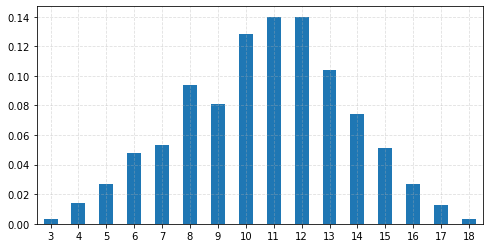

In [3]:
dice = 3
n = 6
n_samples = 1000

# Make runs repeatable.
rng = np.random.default_rng(0)


def get_sampled_sums(dice, n, size, rng, edges=False):
    """Generate samples of the sum of dice.
    
    Parameters
    ----------
    dice : int
        The number of dice to sum.
    n : int
        The number of sides of the dice.
    size : int or None
        The number of samples to sample. If None, a single sample
        will be generated.
    edges : bool
        Return bin edges as the index instead of bin centres.
    
    Returns
    -------
    sampled : pandas Series
        Series containint the probabilities with the bin edges
        or centres as the index.
    
    """
    if size is None:
        size = 1

    samples = random_dice(dice=dice, n=n, rng=rng, size=size)

    # Count the occurrences of each roll.
    occurrences = Counter(samples)
    values, counts = zip(*occurrences.items())

    values = np.asarray(values)
    # Sort the values.
    sort_indices = np.argsort(values)
    values = values[sort_indices]

    # Convert to floats since we will later be computing
    # the corresponding probabilities.
    counts = np.asarray(counts, dtype=np.float64)
    counts = counts[sort_indices]

    # Normalise for comparison with the expected probabilities.
    counts /= np.sum(counts)

    sampled = pd.Series(counts, index=values, name="numerical")
    sampled.name = "sampled"

    if edges:
        sampled.index = [(i, i) for i in sampled.index]

    return sampled


sampled = get_sampled_sums(dice=dice, n=n, size=n_samples, rng=rng)

_ = sampled.plot.bar(figsize=(8, 4), rot=0)

#### Compare sampled values to the analytical results

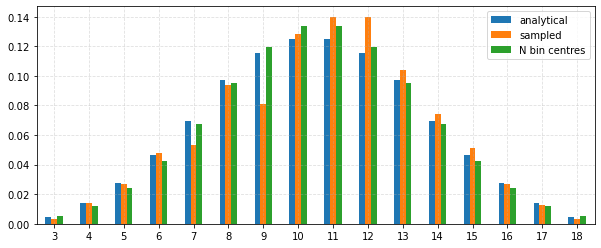

In [4]:
# Get the expected sum and standard deviation
mean = sum_dice_mean(dice=dice, n=n)
std = sum_dice_std(dice=dice, n=n)

# Expected distribution
expected = sum_dice_distr(dice=dice, n=n)
expected.name = "analytical"

distr = norm(loc=mean, scale=std)

# Calculate the pdf at the bin centres.
bin_centres = {}
for bin_centre in expected.index:
    bin_centres[bin_centre] = distr.pdf(bin_centre)

bin_centres = pd.Series(bin_centres)
bin_centres /= np.sum(bin_centres)  # Normalise.
bin_centres.name = "N bin centres"

df = pd.concat((expected, sampled, bin_centres), axis=1)
_ = df.plot.bar(figsize=(10, 4), rot=0)

### Compare continuity correction with the bin centre approach

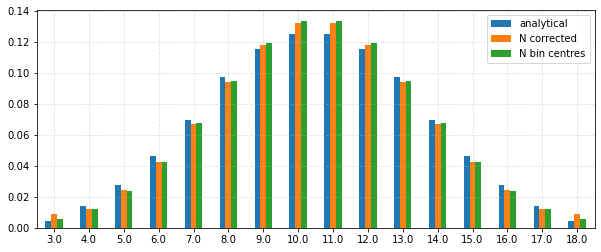

In [5]:
# Use the continuity correction.
def continuity_correction(distr, bin_edges):
    """Calculate the bin probabilities using a continuity correction.
    
    Parameters
    ----------
    distr : object with `cdf` method
        Distribution for which the probabilities should be determined.
    bin_edges : iterable of 2-tuple
        Upper and lower bounds associated with each bin.
        
    Returns
    -------
    corrected : pandas Series
        Series of the probabilities with the bin edges as the index.    
    
    """
    max_i = len(bin_edges) - 1
    corrected = {}
    for i, bin_edge in enumerate(bin_edges):
        if i == 0:
            corrected[bin_edge] = distr.cdf(bin_edge[1] + 0.5)
        elif i == max_i:
            corrected[bin_edge] = 1 - distr.cdf(bin_edge[0] - 0.5)
        else:
            corrected[bin_edge] = distr.cdf(bin_edge[1] + 0.5) - distr.cdf(
                bin_edge[0] - 0.5
            )
    return pd.Series(corrected)


corrected = continuity_correction(distr, [(i, i) for i in expected.index])
# Get bin centres back from the bin edges.
corrected.index = [np.mean(i) for i in corrected.index]
corrected.name = "N corrected"
assert np.isclose(corrected.sum(), 1)
df_corr = pd.concat((df, corrected), axis=1)
_ = df_corr.plot.bar(
    y=["analytical", "N corrected", "N bin centres"], figsize=(10, 4), rot=0
)

### Write a function that joins adjacent bins with probabilities that are too low

In [6]:
def join_bins(bin_edges, probabilities, min_prob=0.05):
    """Join bins until at least the minimum probability is contained.

    By joining adjacent bins, find the configuration with the maximum
    number of bins that each contain at least a certain probability.

    Parameters
    ----------
    bin_edges : iterable of 2-tuple
        Upper and lower bounds associated with each bin.
    probabilities : array-like
        Probabilities in each bin. The contiguous ranges where bin joining
        must be attempted will automatically be determined.
    min_prob : float
        The minimum probability (inclusive) per (final) bin.
        
    Returns
    -------
    bin_edges : list of 2-tuple
        List containing the new bin edges.
    probabilities : array
        Probabilities corresponding to the above bins.               

    Raises
    ------
    ValueError : If the number of bin edges does not match the number 
        of probabilities.
    ValueError : If the sum of all `probabilities` does not exceed `min_prob`.

    """
    if len(bin_edges) != len(probabilities):
        raise ValueError("Length of bin_edges and probabilities must match.")

    probabilities = np.asarray(probabilities)

    if np.sum(probabilities) <= min_prob:
        raise ValueError("Sum of probabilities must exceed min_prob.")

    max_i = probabilities.shape[0] - 1

    def _join(start_i, end_i):
        """Return new bin edges and probabilities after a join.
        
        Parameters
        ----------
        start_i : int
            Beginning of the join.
        end_i : int
            End of the join.
            
        Returns
        -------
        bin_edges : list of 2-tuple
            List containing the new bin edges.
        probabilities : array
            Probabilities corresponding to the above bins.             
            
        """
        new_bin_edges = []
        new_probabilities = []

        # Remove all but the first index within the join window.
        for i in filterfalse(
            lambda x: x in range(start_i + 1, end_i + 1), range(max_i + 1),
        ):
            if i == start_i:
                new_bin_edges.append((bin_edges[start_i][0], bin_edges[end_i][1],))
                new_probabilities.append(np.sum(probabilities[start_i : end_i + 1]))
            else:
                new_bin_edges.append(bin_edges[i])
                new_probabilities.append(probabilities[i])

        return join_bins(
            bin_edges=new_bin_edges, probabilities=new_probabilities, min_prob=min_prob,
        )

    # Identify regions with low probabilities.
    join_mask = probabilities < min_prob

    if not np.any(join_mask):
        # Joining is complete.
        return (bin_edges, probabilities)

    # Find the contiguous clusters.
    labelled, n_clusters = label(join_mask)

    variations = []

    # Carry out contiguous bin joining around all clusters.

    for cluster_i in range(1, n_clusters + 1):
        cluster_indices = np.where(labelled == cluster_i)[0]
        cluster_bounds = (cluster_indices[0], cluster_indices[-1])
        # Also consider the adjacent bins, since this may be needed
        # in some cases.
        join_bounds = tuple(
            np.clip(np.array([cluster_bounds[0] - 1, cluster_bounds[1] + 1]), 0, max_i)
        )
        for start_i in range(*join_bounds):
            # Optimisation: prevent 'orphan' bins on the left.
            if join_bounds[0] == 0 and start_i != 0:
                continue
            for end_i in range(start_i + 1, join_bounds[1] + 1):
                # Optimisation: prevent 'orphan' bins on the right.
                if join_bounds[1] == max_i and end_i != max_i:
                    continue

                # If the sum of probabilities between `start_i` and `end_i`
                # exceeds the minimum threshold, join the bins.
                if np.sum(probabilities[start_i : end_i + 1]) >= min_prob:
                    variations.append(_join(start_i, end_i))

    # Return the 'best' variation - the set of bins with the lowest variability,
    # measured using the standard deviation of the probabilities. Only sets with
    # the largest number of bins will be considered here.
    lengths = [len(variation[0]) for variation in variations]
    max_length = max(lengths)
    long_variations = [
        variation for variation in variations if len(variation[0]) == max_length
    ]
    variation_stds = [np.std(variation[1]) for variation in long_variations]
    min_index = np.argsort(variation_stds)[0]
    return long_variations[min_index]


bin_edges = [
    (1, 1),
    (2, 2),
    (3, 3),
    (4, 4),
    (5, 5),
    (6, 6),
    (7, 7),
    (8, 8),
    (9, 9),
    (10, 10),
    (11, 11),
    (12, 12),
]
probabilities = [
    0.025,
    0.075,
    0.2,
    0.2,
    0.025,
    0.015,
    0.2,
    0.2,
    0.025,
    0.015,
    0.015,
    0.015,
]
bins_old = pd.DataFrame(
    {"bin_edge": bin_edges, "probability": probabilities}
).set_index("bin_edge")

display_html(bins_old)

new_edges, new_probs = join_bins(bin_edges, probabilities, min_prob=0.06)
print("Joined bins:")
bins_new = pd.DataFrame({"bin_edge": new_edges, "probability": new_probs}).set_index(
    "bin_edge"
)
display_html(bins_new)

,probability
bin_edge,
"(1, 1)",0.025
"(2, 2)",0.075
"(3, 3)",0.200
"(4, 4)",0.200
"(5, 5)",0.025
"(6, 6)",0.015
"(7, 7)",0.200
"(8, 8)",0.200
"(9, 9)",0.025


Joined bins:


,probability
bin_edge,
"(1, 2)",0.100
"(3, 3)",0.200
"(4, 5)",0.225
"(6, 7)",0.215
"(8, 8)",0.200
"(9, 12)",0.070


### Test the CLT

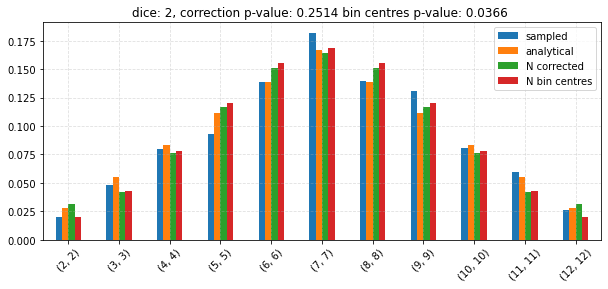

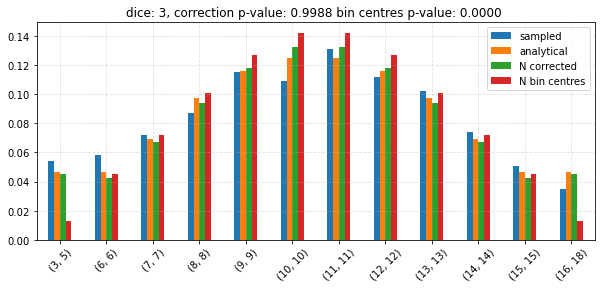

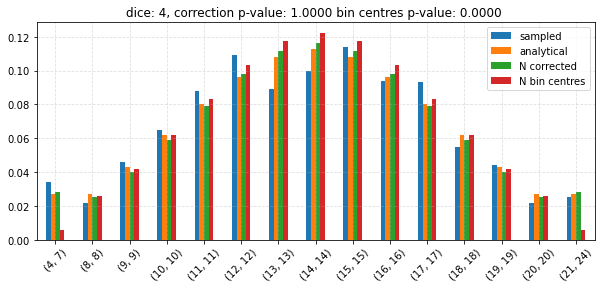

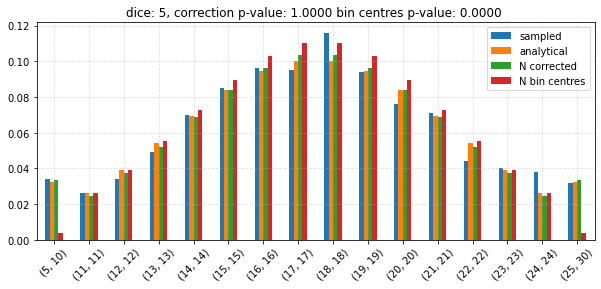

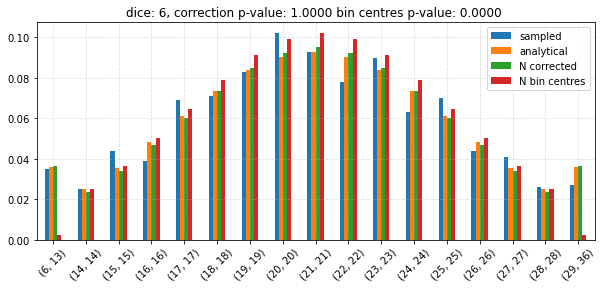

In [7]:
# Make runs repeatable.
rng = np.random.default_rng(0)

n = 6
n_samples = 1000

distributions = []
for dice in tqdm(np.unique(np.linspace(2, 6, 10, dtype=np.int64))):
    # Get the expected sum and standard deviation
    mean = sum_dice_mean(dice=dice, n=n)
    std = sum_dice_std(dice=dice, n=n)

    # CLT.
    distr = norm(loc=mean, scale=std)

    # Expected distribution
    expected = sum_dice_distr(dice=dice, n=n)
    # Use bin edges as the index.
    expected.index = [(i, i) for i in expected.index]

    # Construct bins such that at least 20 are expected to be contained
    # within each bin.
    edges, probs_vals = join_bins(
        bin_edges=expected.index, probabilities=expected.values, min_prob=20 / n_samples
    )
    # Redefine the expected probabilities using the new bin edges.
    expected = pd.Series(probs_vals, index=edges)
    expected.name = "analytical"

    # Calculate the pdf at the bin centres.
    bin_centres = {}
    for bin_edge in expected.index:
        bin_centres[bin_edge] = distr.pdf(np.mean(bin_edge))

    bin_centres = pd.Series(bin_centres)
    bin_centres /= np.sum(bin_centres)  # Normalise.
    bin_centres.name = "N bin centres"
    # We actually want the tuple as the index, without a multi index.
    bin_centres.index = bin_centres.index.to_flat_index()

    corrected = continuity_correction(distr, expected.index)
    corrected.name = "N corrected"

    assert np.isclose(corrected.sum(), 1)

    sampled = get_sampled_sums(dice=dice, n=n, size=n_samples, rng=rng, edges=False)
    # Sort for more efficient grouping by bin edges below.
    sampled.sort_index(inplace=True)

    sampled_centres = sampled.index.tolist()
    sampled_vals = sampled.values.tolist()

    # Apply the above bin edges to the sampled values.
    new_sampled = []
    for bin_edge in edges:
        agg = 0
        while len(sampled_centres) and sampled_centres[0] in range(
            bin_edge[0], bin_edge[1] + 1
        ):
            sampled_centres.pop(0)
            agg += sampled_vals.pop(0)
        new_sampled.append(agg)

    sampled = pd.Series(new_sampled, index=edges)
    sampled.name = "sampled"

    df = pd.concat((expected, sampled, bin_centres, corrected), axis=1)

    ax = df.plot.bar(
        y=["sampled", "analytical", "N corrected", "N bin centres"],
        figsize=(10, 4),
        rot=45,
    )

    n_corr_p = chisquare(
        f_obs=expected.values * n_samples, f_exp=corrected.values * n_samples
    )[1]
    n_cent_p = chisquare(
        f_obs=expected.values * n_samples, f_exp=bin_centres.values * n_samples
    )[1]

    ax.set_title(
        f"dice: {dice}, correction p-value: {n_corr_p:0.4f} "
        f"bin centres p-value: {n_cent_p:0.4f} "
    )